In [25]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
from src.utils.model import load_experiment,load_exprerimant_by_id
import torch
from torch.autograd import Variable
from src.experiments.static_quantization import quantize_static
from src.experiments.pruning import model_size
from pytorch_grad_cam.utils.image import show_cam_on_image
sns.set(color_codes=True)
import pickle

%matplotlib inline
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
%load_ext autoreload
%autoreload 2

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"
MODEL = "lenet"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mt = torch.FloatTensor(mean).view(3,1,1)
st = torch.FloatTensor(std).view(3,1,1)

def unnormalize(img):
    return img * st + mt


In [3]:
experiments = [
    {'id': "10", 'train_id': "3", 'name': 'resnet18' }, 
    {'id': "7", 'train_id': "7", 'name': 'lenet' }, 
    {'id': "11", 'name': 'lenetplus' },
    {'id': "14", 'train_id': "8", 'name': 'squeezenet' }
]
exp = [m  for m in experiments if m["name"] == MODEL][0]

In [4]:
d = mlflow.search_runs(
    experiment_ids=exp["id"],
    output_format="pandas",
)
if 'train_id' in exp.keys():
    d2 = mlflow.search_runs(
        experiment_ids=exp["train_id"],
        output_format="pandas",
    )
    d = pd.concat([d, d2])

In [117]:
q = d[d["tags.type"] == "quantization"]
q = q[q[AP] == "7"]
q = q[q[WP] == "8"].iloc[0]

pq = d[d["tags.type"] == "pruning + quantization"]
pq = pq[pq[AP] == "7"]
pq = pq[pq[WP] == "8"].iloc[0]

train = d[d["tags.stage"] == "train"].iloc[0]
t_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"])

prun = d[d["tags.pruning_method"] == 'unstructured_l1']
prun = prun[prun["tags.type"] == 'pruning'].iloc[0]
cp = prun["params.model_0.25"]   
if not cp:
    raise Error()
p_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"], compressed_path=cp)

t_model.eval()
q_model = quantize_static(t_model, datamodule.test_dataloader())
qp_model = quantize_static(p_model, datamodule.test_dataloader())


Global seed set to 42
Global seed set to 42


QConfig(activation=functools.partial(<class 'torch.quantization.observer.MovingAverageMinMaxObserver'>, dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine), weight=functools.partial(<class 'torch.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_affine))
QConfig(activation=functools.partial(<class 'torch.quantization.observer.MovingAverageMinMaxObserver'>, dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine), weight=functools.partial(<class 'torch.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_affine))


In [ ]:
def saliency(input, model):
    device = torch.device("cpu:0")
    model.to(device)
    input.to(device)

    for param in model.parameters():
       param.requires_grad = False

    
    input = input.reshape((1,3,32,32))

    model.eval()


    input.requires_grad = True
    preds = model(input)
    score, indices = torch.max(preds, 1)
    # backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    # get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    return slc.numpy()

In [ ]:
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

# test = datamodule.data_test
# image = next(iter(test))[0]


# saliency(image, q_model)


In [10]:

test = datamodule.data_test
image = next(iter(test))[0]

fig = plt.figure(figsize=(12,10))

i = 1
for image, _ in iter(test):
    if i <= 8:
        slc = saliency(image, t_model)
        slc_p = saliency(image, p_model)


        img = unnormalize(image)
        img = img.numpy()
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)

        plt.subplot(4,6, 3*i-2)
        plt.axis('off')
        plt.title("original")
        plt.imshow(img)
        

        plt.subplot(4,6, 3*i-1)
        plt.axis('off')
        plt.title("base model")
        plt.imshow(show_cam_on_image(img, slc))

        plt.subplot(4,6, 3*i)
        plt.axis('off')
        plt.title("pruned model")
        plt.imshow(show_cam_on_image(img, slc_p))
    i += 1
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/saliency/s-{MODEL}-pfp-cam.jpg')

NameError: name 'datamodule' is not defined

In [ ]:
from tqdm import tqdm

i = 0
slcs = []
slcs_p = []

targs = []
imgs = []
for image, target in tqdm(datamodule.data_test):
    if i > 1000:
        break
    i += 1

    slc = saliency(image, t_model)
    slc_p = saliency(image, p_model)

    img = unnormalize(image)
    img = img.numpy()
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)

    slcs.append(slc)
    slcs_p.append(slc_p)
    targs.append(target)
    imgs.append(img)
  

 10%|█         | 1001/10000 [00:09<01:29, 100.82it/s]


In [ ]:
data = {"imgs": imgs, "slc": slcs, "targs": targs}
data_p = {"slc": slcs_p}


with open(f"/home/k.schwienbacher/quantization-robustness/data/saliency/{MODEL}", "wb") as f:
    pickle.dump(data, f)
with open(f"/home/k.schwienbacher/quantization-robustness/data/saliency/{MODEL}-p", "wb") as f:
    pickle.dump(data_p, f)



In [5]:
with open(f"/home/k.schwienbacher/quantization-robustness/data/saliency/{MODEL}", "rb") as f:
    data = pickle.load(f)
with open(f"/home/k.schwienbacher/quantization-robustness/data/saliency/{MODEL}-p", "rb") as f:
    data_p = pickle.load(f)

slcs = data["slc"]
slcs_p = data_p["slc"]
imgs = data["imgs"]
targs = data["targs"]

<AxesSubplot:>

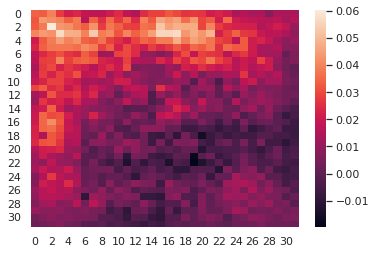

In [6]:
s = np.array(slcs)
sp = np.array(slcs_p)

m = s - sp
mse = np.abs(m.mean(axis=1).mean(axis=1))


sns.heatmap(m.mean(axis=0))

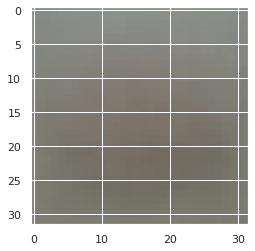

In [7]:
plt.imshow(np.array(imgs).mean(axis=0))

In [8]:
top8 = mse.argsort()[-8:][::-1]

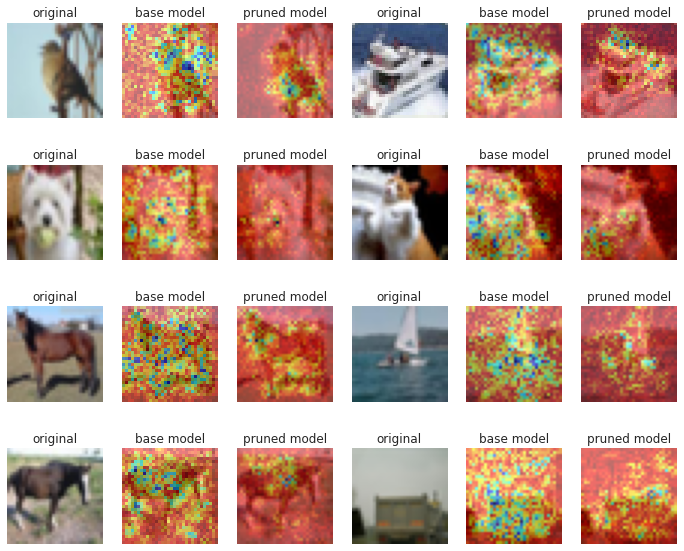

In [12]:
fig = plt.figure(figsize=(12,10))

n = 1
for i in top8:
    plt.subplot(4,6, 3*n-2)
    plt.axis('off')
    plt.title("original")
    plt.imshow(imgs[i])

    plt.subplot(4,6, 3*n-1)
    plt.axis('off')
    plt.title("base model")
    plt.imshow(show_cam_on_image(imgs[i], slcs[i]))

    plt.subplot(4,6, 3*n)
    plt.axis('off')
    plt.title("pruned model")
    plt.imshow(show_cam_on_image(imgs[i], slcs_p[i]))
    n += 1
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/saliency/s-{MODEL}-top8.jpg')


In [17]:
m = np.zeros(10)
c = np.zeros(10)
for i in range(len(mse)):
    targ = targs[i] 

    m[targ] += mse[i]
    c[targ] += 1



In [24]:
m / c

array([0.03428754, 0.03778565, 0.03716055, 0.03777072, 0.03575331,
       0.04073665, 0.03753831, 0.03547695, 0.04225253, 0.03804338])

In [ ]:
x = np.array(targs)[np.array(top100)]

In [ ]:
unique, counts = np.unique(x, return_counts=True)

np.asarray((unique, counts)).T

array([[ 0, 17],
       [ 1,  5],
       [ 2, 10],
       [ 3, 11],
       [ 4, 12],
       [ 5,  8],
       [ 6, 17],
       [ 7,  8],
       [ 8,  4],
       [ 9,  8]])